# pycen
Lightweight Python package for exploring and acquiring U.S. Census data with intuitive spatial integration.

In [1]:
import pycen
from pycen import explore, acquire

## 3. Acquire (tabular census data)
- `acquire.get_census()` -- census data only (tabular)
    - <mark>this notebook</mark>
- `acquire.get_boundaries()` -- boundary files (spatial)
    - see `4_acquire_spatial-advanced.ipynb` for details
- `acquire.get_censhp()` -- **both at once** (GeoDataframe) 
    - see `2_acquire_spatial.ipynb` for details
---
`acquire.get_census()` shares the same core API as `get_censhp`, so many examples and parameter explanations from `2_acquire_spaital.ipynb` apply directly. However, `get_census` returns tabular data only (no geometry), so spatial-only features are not available: **no clipping via place/cbsa/csa/zcta**, no `quick_viz` maps, and no geometry‑based joins or boundary operations. For those, use get_censhp and refer to the spatial tutorials.

In [2]:
pycen.get_product()

product  label          years                 desc                               
-------  -------------  --------------------  -----------------------------------
acs1     ACS 1-year     2005-2019, 2021-2023  annual; large geos only            
acs5     ACS 5-year     2009-2023             most commonly used                 
dec_pl   Decennial PL   2010, 2020            block-level counts                 
dec_sf1  Decennial SF1  2000, 2010            population + housing (discontinued)


In [3]:
pycen.get_geography()

product  lowest              available (select)
-------  ------------------  ------------------
acs1     county subdivision  place, county subdivision, county, PUMA
                             congressional district, urban area, state, CBSA, CSA
                             division, region, us
acs5     block group         block group, tract, place, county subdivision, county
                             ZCTA, PUMA, congressional district, urban area, state
                             CBSA, CSA, division, region, us
dec_pl   block               block, block group, tract, place, ZCTA, county, state
dec_sf1  block               block, block group, tract, place, ZCTA, county, state
Note: full lists are available at https://api.census.gov/data/<year>/<dataset>/geography.html


### 3.1 single-year, single-geography

Resolving geography...
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Loading from cache: pycen_cache/api/acs5_2023_county_06_001_cd11473140cd4620.csv


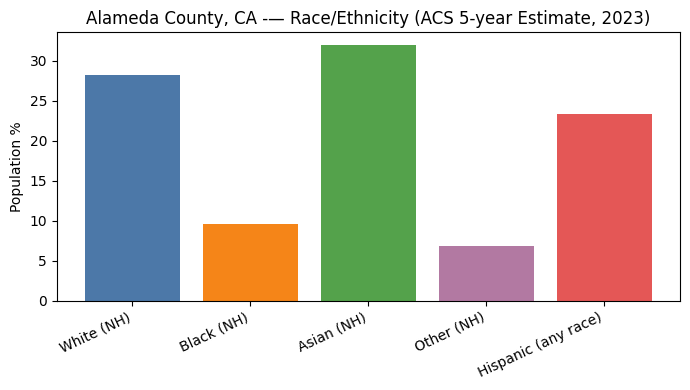

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pycen import acquire

vars_race = {
    'B03002_001E': 'total',
    'B03002_003E': 'nh_white',
    'B03002_004E': 'nh_black',
    'B03002_006E': 'nh_asian',
    'B03002_005E': 'nh_aian',
    'B03002_007E': 'nh_nhpi',
    'B03002_008E': 'nh_other',
    'B03002_009E': 'nh_two_or_more',
    'B03002_012E': 'hispanic',
}

df_race = acquire.get_census(
    variables=vars_race,
    geography='county',
    state='CA',
    county='Alameda',
    dataset='acs5',
    year=2023,
)

row = df_race.iloc[0]
other = row['nh_aian'] + row['nh_nhpi'] + row['nh_other'] + row['nh_two_or_more']
vals = {
    'White (NH)': row['nh_white'],
    'Black (NH)': row['nh_black'],
    'Asian (NH)': row['nh_asian'],
    'Other (NH)': other,
    'Hispanic (any race)': row['hispanic'],
}

pct = {k: v / row['total'] * 100 for k, v in vals.items()}

plt.figure(figsize=(7, 4))
plt.bar(pct.keys(), pct.values(), color=['#4c78a8', '#f58518', '#54a24b', '#b279a2', '#e45756'])
plt.ylabel('Population %')
plt.title('Alameda County, CA -— Race/Ethnicity (ACS 5-year Estimate, 2023)')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

### 3.2 multi-year, single-geography


--- Year 2019 ---


Resolving geography...
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Loading from cache: pycen_cache/api/acs5_2019_county_06_001_cb4e0d76dac904c4.csv

--- Year 2020 ---


Resolving geography...
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Loading from cache: pycen_cache/api/acs5_2020_county_06_001_a8ed54e33b479640.csv

--- Year 2021 ---


Resolving geography...
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Loading from cache: pycen_cache/api/acs5_2021_county_06_001_990b933e8e58e526.csv


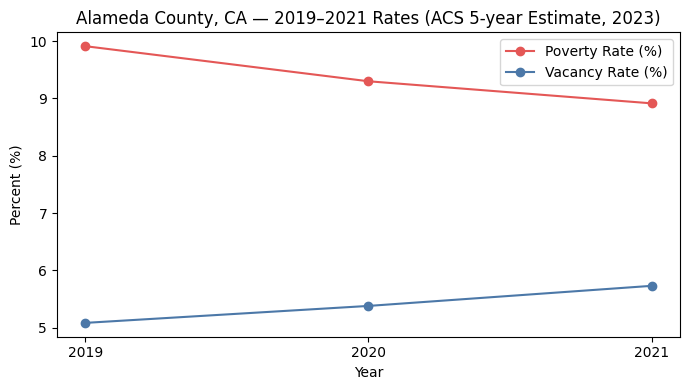

In [5]:
# 2019–2021 line comparative trends
import matplotlib.pyplot as plt
from pycen import acquire

vars_trend = {
    'B17001_001E': 'poverty_total',
    'B17001_002E': 'poverty_below',
    'B25002_001E': 'housing_total',
    'B25002_003E': 'housing_vacant',
}

df_trend = acquire.get_census(
    variables=vars_trend,
    geography='county',
    county='Alameda',
    state='CA',
    dataset='acs5',
    years=[2019, 2020, 2021],
    merge='long',
)

tr = df_trend.sort_values('year')
tr['poverty_pct'] = tr['poverty_below'] / tr['poverty_total'] * 100
tr['vacancy_pct'] = tr['housing_vacant'] / tr['housing_total'] * 100

plt.figure(figsize=(7, 4))
plt.plot(tr['year'], tr['poverty_pct'], marker='o', color='#e45756', label='Poverty Rate (%)')
plt.plot(tr['year'], tr['vacancy_pct'], marker='o', color='#4c78a8', label='Vacancy Rate (%)')
plt.title('Alameda County, CA — 2019–2021 Rates (ACS 5-year Estimate, 2023)')
plt.xlabel('Year')
plt.xticks(sorted(tr['year'].unique()))
plt.ylabel('Percent (%)')
plt.legend()
plt.tight_layout()
plt.show()

### 3.3 multi-year, multi-geography

In [6]:
explore.lookup('B08006_017E', dataset='acs5',year=2021)


Variable: B08006_017E
Label: Estimate!!Total:!!Worked from home
Concept: SEX OF WORKERS BY MEANS OF TRANSPORTATION TO WORK
Type: int
Group: B08006
Year: 2021
Dataset: ACS5



--- Year 2019 ---


Resolving geography...
  State: California (CA, FIPS: 06)
Loading from cache: pycen_cache/api/acs1_2019_county_06__11f8bda99f003d46.csv

--- Year 2021 ---


Resolving geography...
  State: California (CA, FIPS: 06)
Loading from cache: pycen_cache/api/acs1_2021_county_06__fd0a194284bbc442.csv

--- Year 2022 ---


Resolving geography...
  State: California (CA, FIPS: 06)
Loading from cache: pycen_cache/api/acs1_2022_county_06__cf6468b8884e3e4a.csv

--- Year 2023 ---


Resolving geography...
  State: California (CA, FIPS: 06)
Loading from cache: pycen_cache/api/acs1_2023_county_06__771cfbb6f5fa7c43.csv


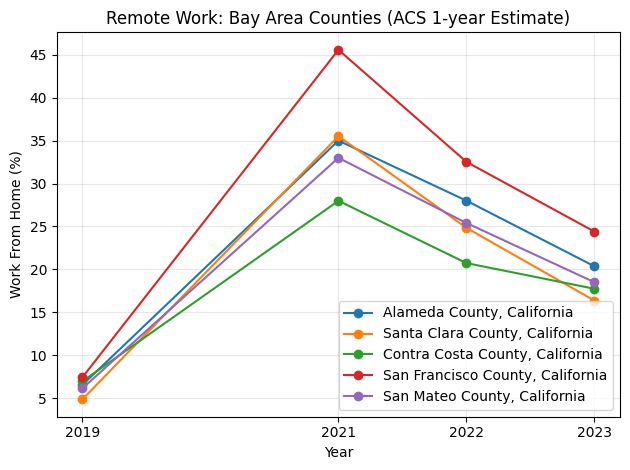

In [ ]:
# track remote work surge using ACS 1-year estimates
# B08101_049E = worked from home
# census reference on using acs1 vs acs5: 
# https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch03.pdf                                                                         
                                                                                                               
df_long = acquire.get_census(
    variables={'B08006_017E': 'wfh_workers', 'B08101_001E': 'total_workers'},
    geography='county',
    state='CA',
    years=[2019, 2021, 2022, 2023],  # no 1-year data for 2020
    dataset='acs1',
    merge='long'
)                                                                                                            

# calc WFH percentage                                                                                   
df_long['wfh_pct'] = (df_long['wfh_workers'] / df_long['total_workers']) * 100                               

# focus on major counties
major = df_long[df_long['NAME'].str.contains('San Francisco|Alameda|Santa Clara|Contra Costa|San Mateo')]
# plot
import matplotlib.pyplot as plt
for county in major['NAME'].unique():
    county_data = major[major['NAME'] == county]
    plt.plot(county_data['year'], county_data['wfh_pct'], marker='o', label=county)

plt.title('Remote Work: Bay Area Counties (ACS 1-year Estimate)')
plt.ylabel('Work From Home (%)')
plt.xlabel('Year')
plt.xticks(sorted(major['year'].unique()))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()